In [1]:
import numpy as np
from graphviz import Digraph
import graphviz

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

# PGMs with `tfp`

Let's build a simple model and implement it using TFP.

## PGM

In [2]:
graph = Digraph()

graph.node('a', 'weather')
graph.node('b', 'happiness')

graph.edges(['ab'])

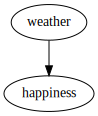

In [3]:
graph

## Implementation

We'll use coroutines to build the model.

### Model assumptions

* $P(Weather=good) = .27$

* $P(Happiness=high|Weather=good) = .925$

* $P(Happiness=high|Weather=bad) = .61$

In [107]:
# Proba of good weather
P_W1 = .27

# Proba of high happiness | bad weather
P_H1_W0 = .61

# Proba of high happiness | good weather
P_H1_W1 = .925

In [109]:
def happiness_model():
    
    weather = yield tfd.JointDistributionCoroutine.Root(
        tfd.Bernoulli(
            probs=P_W1, 
            name='weather') # Poland
    )
    
    weather_to_happiness = tf.constant([P_H1_W0, P_H1_W1])
    
    happiness = yield tfd.Bernoulli(
        probs=weather_to_happiness[weather],
        name='happiness'
    )

In [112]:
# Build a model
joint_model = tfd.JointDistributionCoroutineAutoBatched(happiness_model)

In [113]:
# Examine
joint_model

<tfp.distributions.JointDistributionCoroutineAutoBatched 'JointDistributionCoroutineAutoBatched' batch_shape=[] event_shape=StructTuple(
  weather=[],
  happiness=[]
) dtype=StructTuple(
  weather=int32,
  happiness=int32
)>

In [114]:
# Sample from the model
sample = joint_model.sample(20)

In [115]:
sample

StructTuple(
  weather=<tf.Tensor: shape=(20,), dtype=int32, numpy=array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])>,
  happiness=<tf.Tensor: shape=(20,), dtype=int32, numpy=array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1])>
)

### Sanity checks

In [116]:
# Sanity checks
joint_model.prob([1, 1]).numpy(), P_W1 * P_H1_W1

(0.24974999, 0.24975000000000003)

In [117]:
joint_model.prob([0, 1]).numpy(), (1 - P_W1) * (P_H1_W0) 

(0.4453, 0.4453)

In [118]:
joint_model.prob([1, 0]).numpy(), P_W1 * (1 - P_H1_W1)

(0.020249994, 0.02024999999999999)